In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_absolute_percentage_error, make_scorer, mean_squared_error

from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
import lightgbm as lgb
import shap
import optuna

plt.style.use('seaborn-v0_8')

In [2]:
datapath = 'data_preprocess'
filename = os.path.join(datapath, 'salary_preprocess_v1.csv')

df = pd.read_csv(filename)

In [3]:
df['Salary'].describe()

count      6538.000000
mean     115331.195779
std       52282.673755
min       25000.000000
25%       70000.000000
50%      115000.000000
75%      160000.000000
max      219000.000000
Name: Salary, dtype: float64

In [4]:
df.tail(3)

,Gender,Education_Level,Years_of_Experience,Country,Race,Job_Title,Salary
6535,0,1,4.0,2,4,12,55000.0
6536,1,4,14.0,2,6,35,140000.0
6537,0,2,1.0,1,3,45,35000.0


In [5]:
def split_dataset(df, frac_train):
    
    assert frac_train < 1

    df_train = df.sample(frac=frac_train, random_state=2).reset_index(drop=True)
    df_val = df.drop(df_train.index).reset_index(drop=True)

    return df_train, df_val

In [6]:
def objective(trial, n_model, df_train):

    X_train = df_train.drop(['Salary'], axis=1)
    y_train = df_train['Salary']

    assert (n_model=='LGBMRegressor' or n_model=='XGBRegressor' or n_model=='DecisionTreeRegressor'), 'escolha entre LGBMRegressor, XGBRegressor ou LinearRegression'
    
    if n_model == 'LGBMRegressor':
        d_params = {"verbosity": -1,
                    'n_estimators': trial.suggest_int('n_estimators', 1000, 2500, 100),
                    "learning_rate": trial.suggest_float("learning_rate", 5e-3, 0.1, log=True),
                    "num_leaves": trial.suggest_int("num_leaves", 10, 300),
                    "subsample": trial.suggest_float("subsample", 0.5, 1.0),
                    "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
                    "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 10)
                    }
    
        model = lgb.LGBMRegressor(**d_params)
    
    if n_model == 'XGBRegressor':
        d_params = {'devide': 'cuda',
                    'verbosity': 0,
                    'n_estimators': trial.suggest_int('n_estimators', 1000, 2500, 100),
                    'eta': trial.suggest_float('eta', 5e-3, 0.1),
                    'subsample': trial.suggest_float('subsample', 0.5, 1.),
                    'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.),
                    'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1.),
                    }

        model = xgb.XGBRegressor(**d_params)
    
    if n_model == 'DecisionTreeRegressor':
        d_params = {"min_samples_split": trial.suggest_int('min_samples_split', 2, 500),
                    "min_samples_leaf":  trial.suggest_int('min_samples_leaf', 1, 500),
                    }

        model = DecisionTreeRegressor(**d_params)

    ### treino com cross validation
    kf = KFold(n_splits=5, shuffle=True)
    rmse = make_scorer(mean_squared_error, squared=False)
    
    scores = cross_val_score(model, X_train, y_train, scoring=rmse, cv=kf)

    return np.mean(scores)

In [7]:
def best_model(model, df_train, df_val):

    X_train = df_train.drop(['Salary'], axis=1)
    y_train = df_train['Salary']
    X_val = df_val.drop(['Salary'], axis=1)
    y_val = df_val['Salary']

    ### treino a partir dos hiperparametros de melhor score
    model.fit(X_train, y_train)
    y_pred = model.predict(X_train)
    resid = y_train-y_pred#/y_train
    df_train_rmse = pd.DataFrame({'Y_train': y_train, 'Y_pred': y_pred, 'error_res_square': resid})

    y_pred = model.predict(X_val)
    resid = y_val-y_pred#/y_train
    df_val_rmse = pd.DataFrame({'Y_val': y_val, 'Y_pred': y_pred, 'error_res_square': resid})

    return model, df_train_rmse, df_val_rmse

In [8]:
def plot_result(df_train_rmse, df_val_rmse):

    plt.figure(figsize=(12, 5))

    plt.subplot(121)
    min_ = int(df_train_rmse['Y_train'].min())
    max_ = int(df_train_rmse['Y_train'].max())
    plt.plot(range(min_, max_), range(min_, max_), color='r', label='modelo perfeito')
    plt.scatter(df_train_rmse['Y_pred'], df_train_rmse['Y_train'], s=10)
    plt.xlabel('Predict', fontsize=14)
    plt.ylabel('True', fontsize=14)
    plt.legend(['modelo perfeito'])

    plt.subplot(122)
    plt.title('Histograma dos residuos', fontsize=12)
    df_train_rmse['error_res_square'].hist(bins=50)
    plt.xlabel('Residuo', fontsize=14)
    plt.ylabel('Frequência', fontsize=14)
    rmse_train = mean_squared_error(df_train_rmse['Y_train'], df_train_rmse['Y_pred'], squared=False)
    plt.suptitle('Treino \n RMSE: {:.3e}' .format(rmse_train), fontsize=16)
    plt.show()

    plt.figure(figsize=(12, 5))
    plt.subplot(121)
    min_ = int(df_val_rmse['Y_val'].min())
    max_ = int(df_val_rmse['Y_val'].max())
    plt.plot(range(min_, max_), range(min_, max_), color='r', label='modelo perfeito')
    plt.scatter(df_val_rmse['Y_pred'], df_val_rmse['Y_val'], s=10)
    plt.xlabel('Predict', fontsize=14)
    plt.ylabel('True', fontsize=14)
    plt.legend(['modelo perfeito'])

    plt.subplot(122)
    plt.title('Histograma dos residuos', fontsize=12)
    df_val_rmse['error_res_square'].hist(bins=50)
    plt.xlabel('Residuo', fontsize=14)
    plt.ylabel('Frequência', fontsize=14)
    rmse_val = mean_squared_error(df_val_rmse['Y_val'], df_val_rmse['Y_pred'], squared=False)
    plt.suptitle('Validação \n RMSE: {:.3e}' .format(rmse_val), fontsize=16)

    plt.show()

    return rmse_train, rmse_val

In [9]:
### divisão da base de treino e validação
df_train, df_val = split_dataset(df, frac_train=.8)

[I 2023-11-04 15:40:52,865] A new study created in memory with name: no-name-7f14ac94-3c45-4083-9287-97bb8976699a
[I 2023-11-04 15:40:52,908] Trial 0 finished with value: 19742.072652839663 and parameters: {'min_samples_split': 191, 'min_samples_leaf': 76}. Best is trial 0 with value: 19742.072652839663.
[I 2023-11-04 15:40:52,943] Trial 1 finished with value: 25581.673127033348 and parameters: {'min_samples_split': 63, 'min_samples_leaf': 295}. Best is trial 0 with value: 19742.072652839663.
[I 2023-11-04 15:40:52,975] Trial 2 finished with value: 27304.714778159465 and parameters: {'min_samples_split': 288, 'min_samples_leaf': 401}. Best is trial 0 with value: 19742.072652839663.
[I 2023-11-04 15:40:53,006] Trial 3 finished with value: 27582.260372528544 and parameters: {'min_samples_split': 409, 'min_samples_leaf': 448}. Best is trial 0 with value: 19742.072652839663.
[I 2023-11-04 15:40:53,039] Trial 4 finished with value: 22186.48290471472 and parameters: {'min_samples_split': 388

Best hyperparameters: {'min_samples_split': 5, 'min_samples_leaf': 72}
Best RMSE: 19219.789299908258


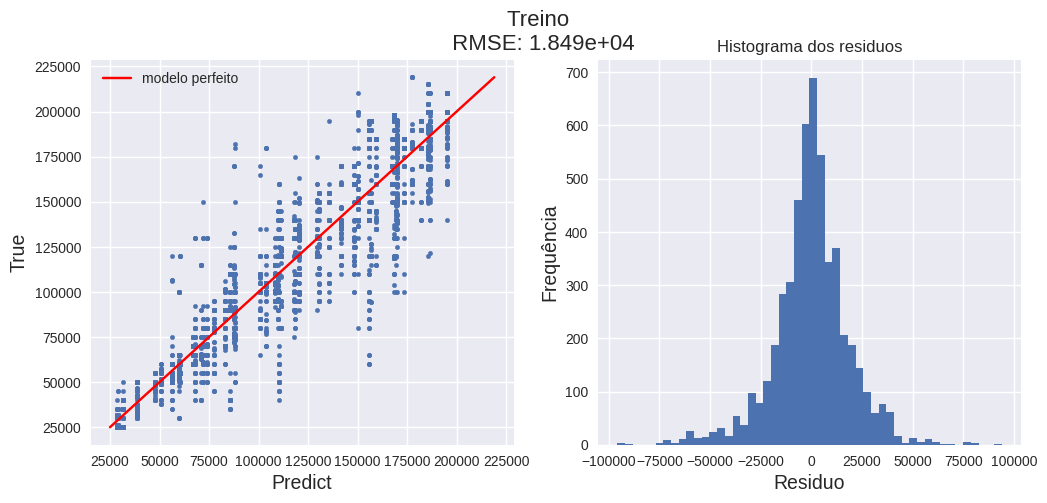

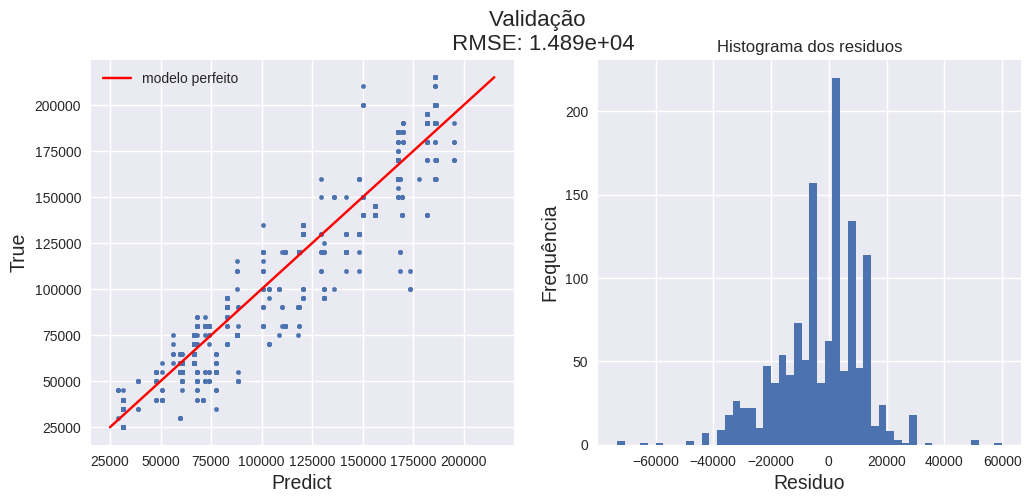

In [10]:
### otimização de hiperparametros
    
n_model = 'DecisionTreeRegressor'

study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: objective(trial, n_model, df_train), n_trials=10)

### Treino e validação com o modelo com o melhore conjunto de hiperparametros

top_params =  study.best_params
top_score = study.best_value

print('Best hyperparameters:', top_params)
print('Best RMSE:', top_score)

model_decis = DecisionTreeRegressor(**top_params)
model_decis_trained, df_train_rmse, df_val_rmse = best_model(model_decis, df_train, df_val)

### Plotagem de resultados
rmse_train_decis, rmse_val_decis = plot_result(df_train_rmse, df_val_rmse)

[I 2023-11-04 15:40:54,377] A new study created in memory with name: no-name-1ec08d04-ac92-47d7-869a-e1bad49515f8
[I 2023-11-04 15:40:58,507] Trial 0 finished with value: 9360.508489888776 and parameters: {'n_estimators': 1800, 'eta': 0.048262680216961375, 'subsample': 0.8078765107932618, 'colsample_bytree': 0.7114310073353951, 'colsample_bylevel': 0.7313647242123298}. Best is trial 0 with value: 9360.508489888776.
[I 2023-11-04 15:41:03,919] Trial 1 finished with value: 9722.704901450556 and parameters: {'n_estimators': 2400, 'eta': 0.06727757862226094, 'subsample': 0.879728613437585, 'colsample_bytree': 0.6013857746886679, 'colsample_bylevel': 0.6853771528448831}. Best is trial 0 with value: 9360.508489888776.
[I 2023-11-04 15:41:07,511] Trial 2 finished with value: 9401.514093953298 and parameters: {'n_estimators': 1600, 'eta': 0.05360381203830139, 'subsample': 0.851755946173872, 'colsample_bytree': 0.598865710000658, 'colsample_bylevel': 0.6705715381107776}. Best is trial 0 with va

Best hyperparameters: {'n_estimators': 1000, 'eta': 0.06780669382101187, 'subsample': 0.8053104206892151, 'colsample_bytree': 0.972407460156947, 'colsample_bylevel': 0.7166925316970879, 'verbosity': 0}
Best RMSE: 9176.509517230916


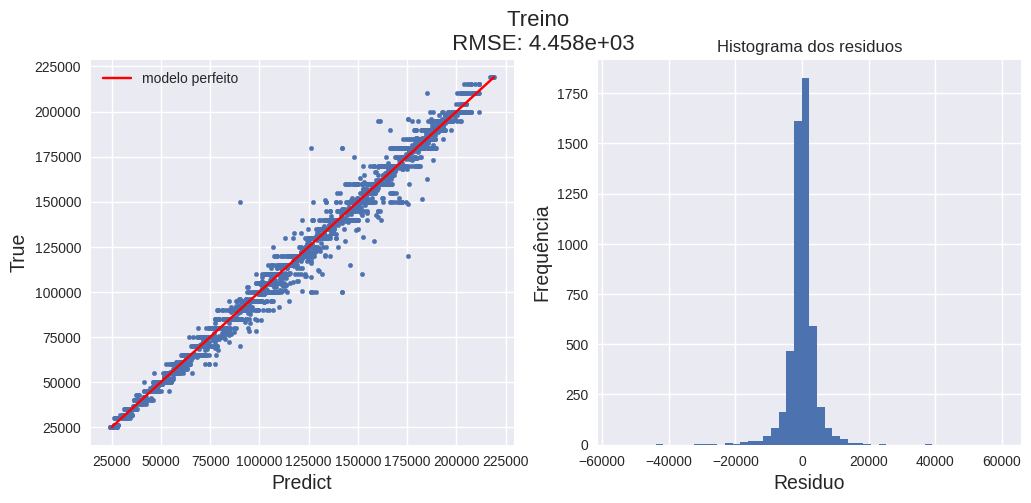

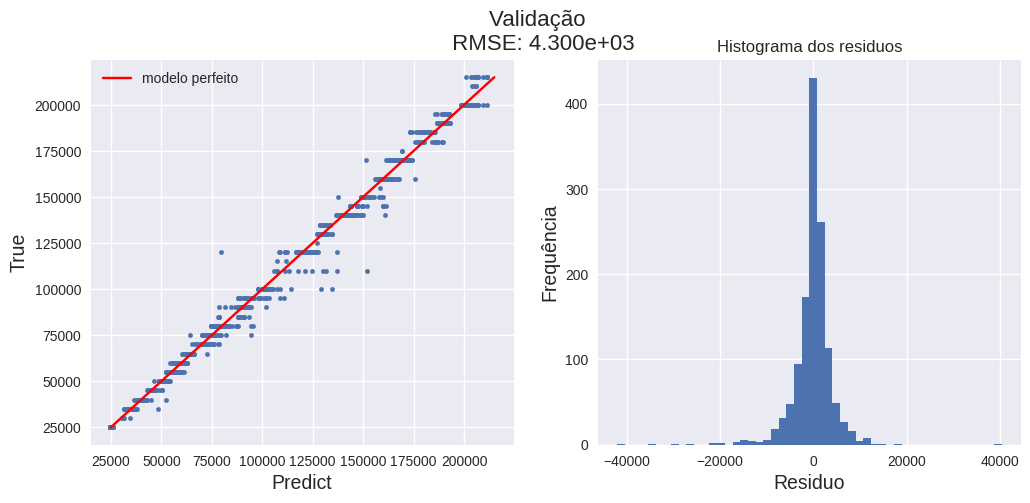

In [11]:
### otimização de hiperparametros
    
n_model = 'XGBRegressor'

study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: objective(trial, n_model, df_train), n_trials=10)

### Treino e validação com o modelo com o melhore conjunto de hiperparametros

top_params =  study.best_params
top_score = study.best_value
top_params['verbosity'] = 0

print('Best hyperparameters:', top_params)
print('Best RMSE:', top_score)

model_xgb = xgb.XGBRegressor(**top_params)
model_xgb_trained, df_train_rmse, df_val_rmse = best_model(model_xgb, df_train, df_val)

### Plotagem de resultados
rmse_train_xgb, rmse_val_xgb = plot_result(df_train_rmse, df_val_rmse)

[I 2023-11-04 15:41:36,877] A new study created in memory with name: no-name-5c13339e-de21-4ee8-8918-eed115948065
[I 2023-11-04 15:42:02,954] Trial 0 finished with value: 9862.955418171496 and parameters: {'n_estimators': 1800, 'learning_rate': 0.09385836977835119, 'num_leaves': 235, 'subsample': 0.8354108867178761, 'colsample_bytree': 0.5947313071243471, 'min_data_in_leaf': 10}. Best is trial 0 with value: 9862.955418171496.
[I 2023-11-04 15:42:36,395] Trial 1 finished with value: 9397.839888888297 and parameters: {'n_estimators': 1800, 'learning_rate': 0.005283750684507916, 'num_leaves': 272, 'subsample': 0.5426719591358757, 'colsample_bytree': 0.8763384856879175, 'min_data_in_leaf': 6}. Best is trial 1 with value: 9397.839888888297.
[I 2023-11-04 15:42:55,002] Trial 2 finished with value: 9131.540458170815 and parameters: {'n_estimators': 1200, 'learning_rate': 0.007012831231088698, 'num_leaves': 228, 'subsample': 0.9046080776855681, 'colsample_bytree': 0.7912736649972869, 'min_data

Best hyperparameters: {'n_estimators': 1200, 'learning_rate': 0.007012831231088698, 'num_leaves': 228, 'subsample': 0.9046080776855681, 'colsample_bytree': 0.7912736649972869, 'min_data_in_leaf': 3, 'verbosity': -1}
Best RMSE: 9131.540458170815


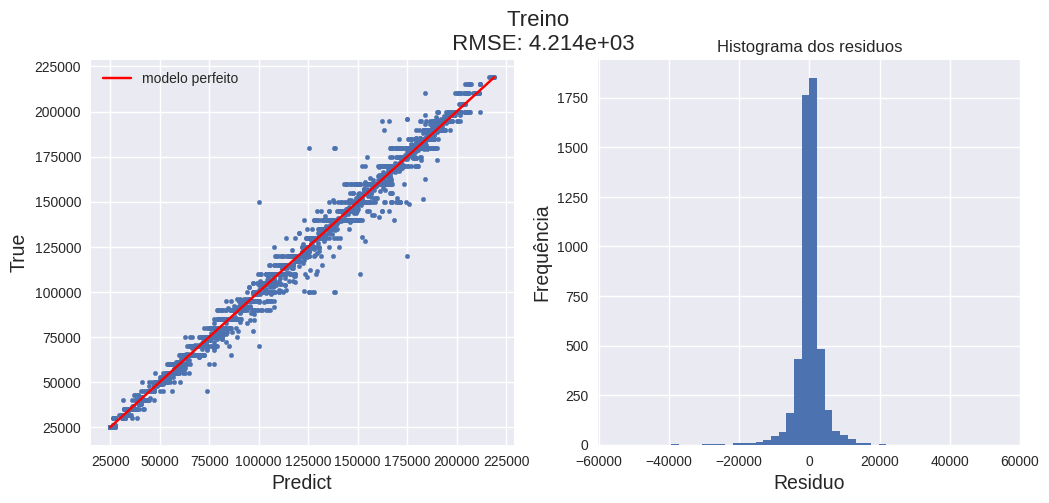

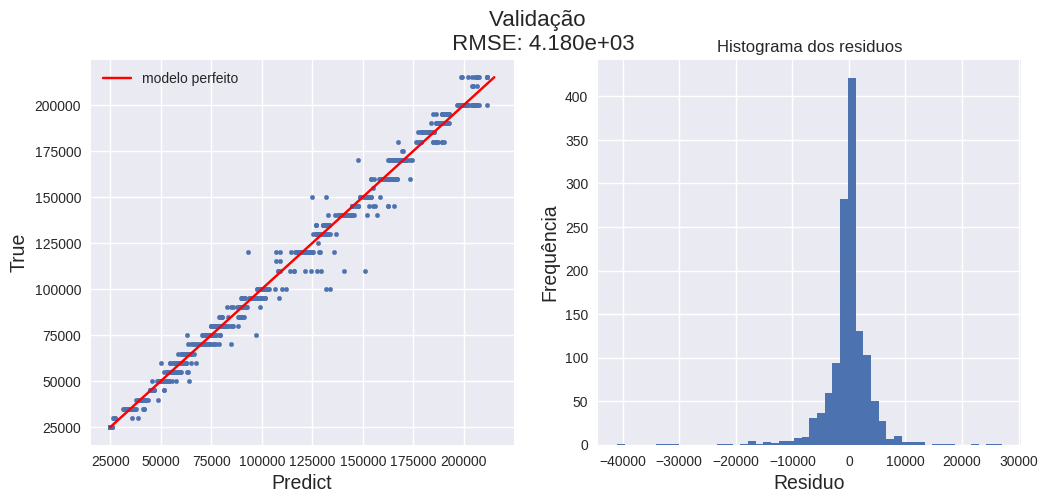

In [12]:
### otimização de hiperparametros
    
n_model = 'LGBMRegressor'

study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: objective(trial, n_model, df_train), n_trials=10)

### Treino e validação com o modelo com o melhore conjunto de hiperparametros

top_params =  study.best_params
top_score = study.best_value
top_params['verbosity'] = -1

print('Best hyperparameters:', top_params)
print('Best RMSE:', top_score)

model_lgb = lgb.LGBMRegressor(**top_params)
model_lgb_trained, df_train_rmse, df_val_rmse = best_model(model_lgb, df_train, df_val)

### Plotagem de resultados
rmse_train_lgb, rmse_val_lgb = plot_result(df_train_rmse, df_val_rmse)

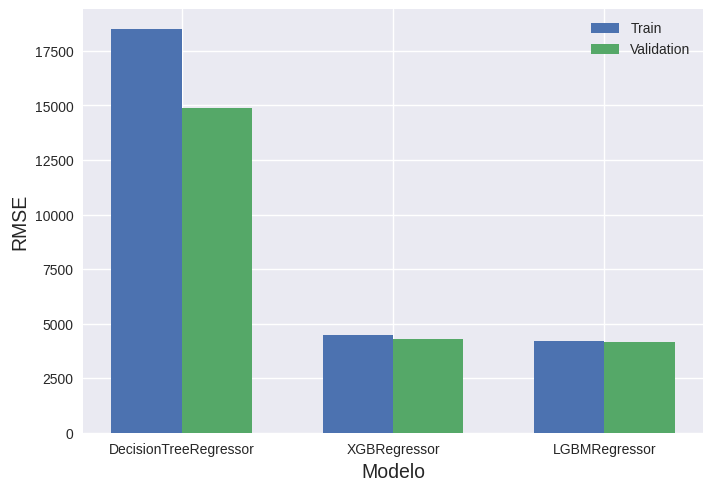

In [13]:
plt.figure()
plt.bar([1, 4, 7], [rmse_train_decis, rmse_train_xgb, rmse_train_lgb], width=1)
plt.bar([2, 5, 8], [rmse_val_decis, rmse_val_xgb, rmse_val_lgb], width=1)
plt.xticks([1.5, 4.5, 7.5], ['DecisionTreeRegressor', 'XGBRegressor', 'LGBMRegressor'])
plt.ylabel('RMSE', fontsize=14)
plt.xlabel('Modelo', fontsize=14)
plt.legend(['Train', 'Validation'])
plt.show()

In [18]:
X_val = df_val.drop(['Salary'], axis=1)
y_val = df_val['Salary']

In [19]:
# Fits the explainer
explainer = shap.Explainer(model_lgb_trained.predict, X_val)
# Calculates the SHAP values - It takes some time
shap_values = explainer(X_val)

ExactExplainer explainer: 1309it [03:35,  5.88it/s]                          


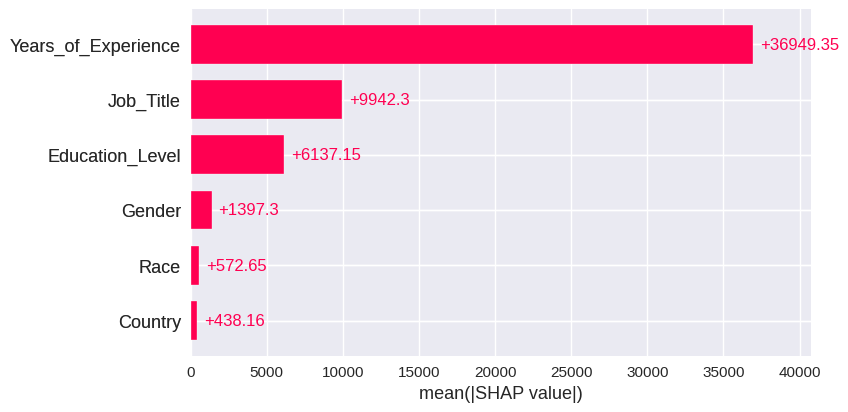

In [25]:
shap.plots.bar(shap_values)

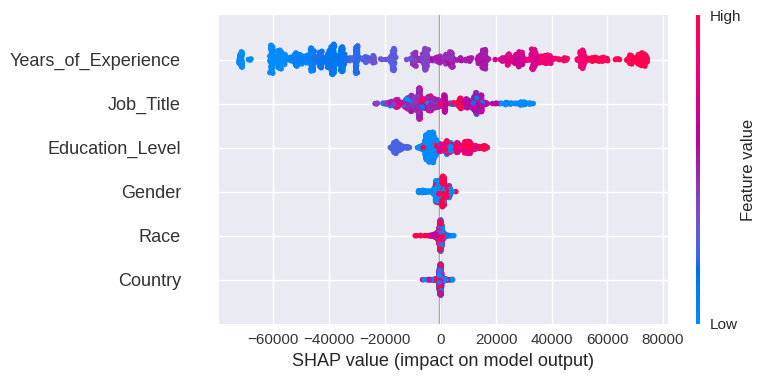

In [21]:
shap.summary_plot(shap_values)